In [1]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.plotting import plot_decision_regions

In [2]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
iris = datasets.load_iris()

In [4]:
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
sepal_length = iris['data'][:, 0]
petal_length = iris['data'][:, 2]

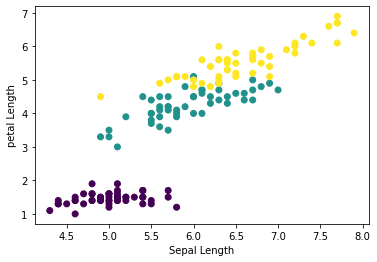

In [6]:
target = iris['target']
plt.scatter(sepal_length, petal_length, c = target)
plt.xlabel('Sepal Length')
plt.ylabel('petal Length')
plt.show()

In [7]:
X = np.column_stack((sepal_length, petal_length))
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state=25)

In [8]:
clf = svm.SVC(kernel = 'linear', C = 1)
clf.fit(x_train, y_train)

SVC(C=1, kernel='linear')

In [9]:
clf.score(x_test, y_test)

0.9666666666666667

<AxesSubplot:>

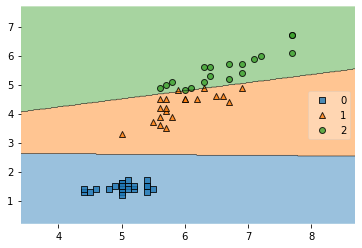

In [10]:
plot_decision_regions(X = x_test, y = y_test, clf = clf, legend=5)

In [11]:
clf.score(x_train, y_train)

0.9666666666666667

<AxesSubplot:>

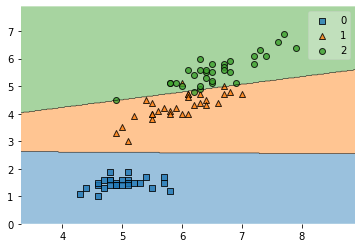

In [12]:
plot_decision_regions(X = x_train, y = y_train, clf = clf, legend = 1)

In [13]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     X,y, test_size=0.4, random_state=25)

# Reduce dimensions
n_dim = 2
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

"""Select
train_size = 120
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 30
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]"""

'Select\ntrain_size = 120\nsample_train = sample_train[:train_size]\nlabel_train = label_train[:train_size]\n\ntest_size = 30\nsample_test = sample_test[:test_size]\nlabel_test = label_test[:test_size]'

In [14]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[ 0.24389338 -0.00658386] 2
[-0.81048217 -0.40968181] 0


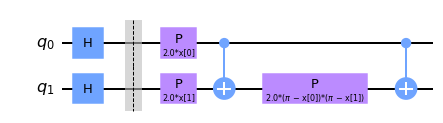

In [15]:
# 2 features, depth 2
map_zz = ZZFeatureMap(feature_dimension = 2, reps = 1, entanglement = 'linear', insert_barriers = True)
map_zz.decompose().draw('mpl')

In [16]:
a = len(sample_train)
print(a)

90


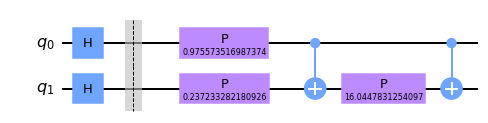

In [17]:
encode_map = map_zz
for i in range (0,a):
    encode_circuit = encode_map.bind_parameters(sample_train[i])
    i = i+1
encode_circuit.decompose().draw(output='mpl')


In [18]:
zz_kernel = QuantumKernel(feature_map = map_zz, quantum_instance = Aer.get_backend('statevector_simulator'))

In [19]:
print(sample_train[0])
print(sample_train[1])

[ 0.24389338 -0.00658386]
[ 0.57847459 -0.06509018]


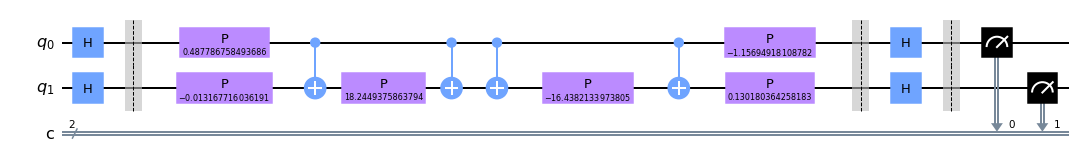

In [20]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

In [21]:
backend = Aer.get_backend('statevector_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

In [22]:
counts['00']/sum(counts.values())

0.3485107421875

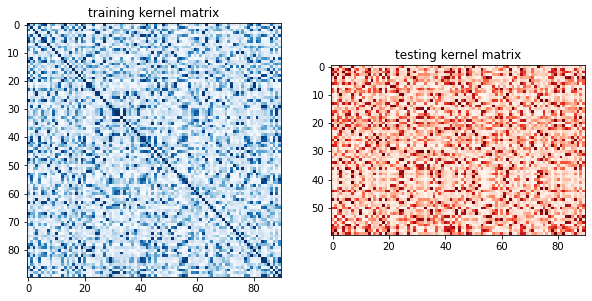

In [23]:
matrix_train = zz_kernel.evaluate(x_vec = sample_train)
matrix_test = zz_kernel.evaluate(x_vec = sample_test, y_vec = sample_train)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation ='nearest', origin ='upper', cmap ='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation ='nearest', origin ='upper', cmap ='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

In [24]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.9666666666666667
